In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree

In [28]:
class BaggingTrees:

    def __init__(self, n_trees=10, max_depth=5, is_classifier=True):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.trees = []
        self.is_classifier = is_classifier

    def fit(self, X, y):
        for i in range(self.n_trees):
            sample = X.sample(frac=1, replace=True)
            if self.is_classifier:
                tree = DecisionTreeClassifier(max_depth=self.max_depth)
            else:
                tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(sample, y.loc[sample.index])
            self.trees.append(tree)

    def predict_classification(self, X):
        predictions = pd.DataFrame()
        for i, tree in enumerate(self.trees):
            predictions[i] = tree.predict(X)
        return predictions.mode(axis=1)[0]
    
    def predict_regression(self, X):
        predictions = pd.DataFrame()
        for i, tree in enumerate(self.trees):
            predictions[i] = tree.predict(X)
        return predictions.mean(axis=1)
    
    
    def predict(self, X):
        if self.is_classifier:
            return self.predict_classification(X)
        else:
            return self.predict_regression(X)
        
    def accuracy(self, X, y):
        return (self.predict(X) == y).mean()
    
    def mse(self, X, y):
        return ((self.predict(X) - y)**2).mean()
    
    def score(self, X, y):
        y = y.reset_index(drop=True)
        if self.is_classifier:
            return self.accuracy(X, y)
        else:
            return self.mse(X, y)
    

# Fitness

In [4]:
fitness = pd.read_csv('data/fitness.txt', sep='\s+')
fitness

,Age,Weight,Oxygen,RunTime,RestPulse,RunPulse,MaxPulse
0,44,89.47,44.609,11.37,62,178,182
1,44,85.84,54.297,8.65,45,156,168
2,38,89.02,49.874,9.22,55,178,180
3,40,75.98,45.681,11.95,70,176,180
4,44,81.42,39.442,13.08,63,174,176
5,44,73.03,50.541,10.13,45,168,168
6,45,66.45,44.754,11.12,51,176,176
7,54,83.12,51.855,10.33,50,166,170
8,51,69.63,40.836,10.95,57,168,172
9,48,91.63,46.774,10.25,48,162,164


In [39]:
# Create the feature matrix X and the target variable y
X = fitness.drop("Oxygen", axis=1)
y = fitness["Oxygen"]

In [48]:
random_ints = np.random.randint(0, 100000, size=100)
mean_scores_trees = []
mean_scores_bagging = []
for i in random_ints:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=i
    )

    tree = DecisionTreeRegressor(max_depth=5)
    tree.fit(X_train, y_train)
    mean_scores_trees.append(((tree.predict(X_test) - y_test)**2).mean())

    bagging = BaggingTrees(n_trees=30, max_depth=5, is_classifier=False)
    bagging.fit(X_train, y_train)
    mean_scores_bagging.append(bagging.score(X_test, y_test))

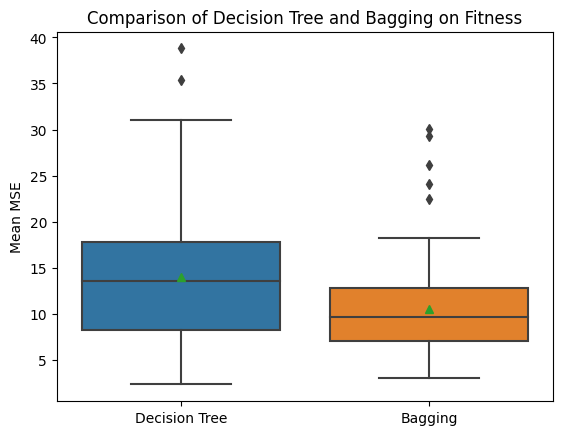

In [50]:
# make a boxplot of the mean scores and compare the two models
sns.boxplot(data=[mean_scores_trees, mean_scores_bagging], showmeans=True)
plt.ylabel("Mean MSE")
plt.title("Comparison of Decision Tree and Bagging on Fitness")
plt.xticks([0, 1], ["Decision Tree", "Bagging"])
plt.show()

# SA heart

In [8]:
sa_data = pd.read_csv('data/SAheart.data')
sa_data = sa_data.drop('row.names', axis=1)
sa_data["famhist"] = sa_data["famhist"].map({"Present": 1, "Absent": 0})

In [9]:
sa_data

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,160,12.00,5.73,23.11,1,49,25.30,97.20,52,1
1,144,0.01,4.41,28.61,0,55,28.87,2.06,63,1
2,118,0.08,3.48,32.28,1,52,29.14,3.81,46,0
3,170,7.50,6.41,38.03,1,51,31.99,24.26,58,1
4,134,13.60,3.50,27.78,1,60,25.99,57.34,49,1
...,...,...,...,...,...,...,...,...,...,...
457,214,0.40,5.98,31.72,0,64,28.45,0.00,58,0
458,182,4.20,4.41,32.10,0,52,28.61,18.72,52,1
459,108,3.00,1.59,15.23,0,40,20.09,26.64,55,0
460,118,5.40,11.61,30.79,0,64,27.35,23.97,40,0


In [10]:
y = sa_data["chd"]
X = sa_data.drop("chd", axis=1)


In [34]:
random_ints = np.random.randint(0, 100000, size=100)
mean_scores_trees = []
mean_scores_bagging = []
for i in random_ints:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=i
    )
    tree = DecisionTreeClassifier(max_depth=5)
    tree.fit(X_train, y_train)

    bagging = BaggingTrees(n_trees=100, max_depth=5, is_classifier=True)
    bagging.fit(X_train, y_train)

    mean_scores_bagging.append(bagging.score(X_test, y_test))
    mean_scores_trees.append(tree.score(X_test, y_test))

0.7073440860215054


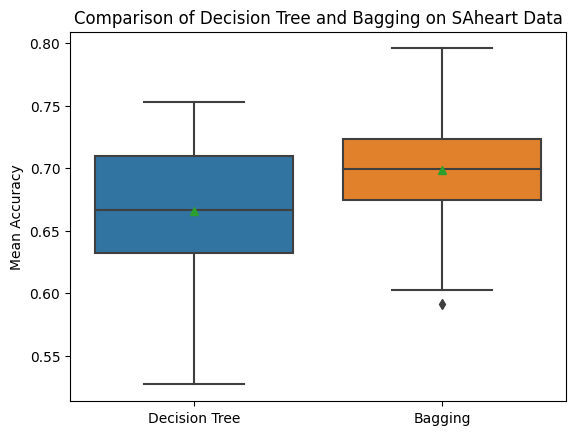

In [36]:
# make a boxplot of the mean scores and compare the two models
sns.boxplot(data=[mean_scores_trees, mean_scores_bagging], showmeans=True)
plt.ylabel("Accuracy")
plt.title("Comparison of Decision Tree and Bagging on SAheart Data")
plt.xticks([0, 1], ["Decision Tree", "Bagging"])
plt.show()
